Додати багатокласову класифікацію (Softmax).

In [1]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#BC371B', '#BC881B', '#4FBC1B'])
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)

In [3]:
class NeuralNet:
    """
    NN for multi-class classification
    Attributes:
    ...
    """
    
    def __init__(self, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * 0.01
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__softmax(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        assert(AL.shape == (3, X.shape[1]))
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__softmax(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            A, caches = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(A, Y, caches)

            self.__update_parameters(grads)

            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [4]:
iris = load_iris()
X = iris.data
Y = iris.target

print('Dataset: X={}, y={}'.format(X.shape, Y.shape))

Dataset: X=(150, 4), y=(150,)


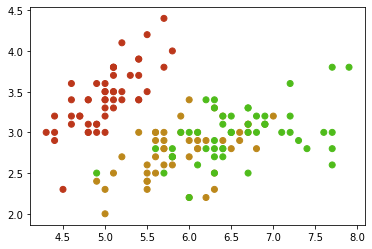

In [5]:
plot_data(X, Y)

In [6]:
cls = NeuralNet(neurons_in_layers = [4, 15, 3], normalize = True, learning_rate = 0.1, num_iter = 2000)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=10)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [8]:
Y_train_transf = np.zeros([len(Y_train), 3])
for i in range(0, len(Y_train)):
    for j in range(0, 3):
        if Y_train[i] == j:
            Y_train_transf[i][j] = 1

Y_train_transf

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

0-th iteration: 0.3662298093773595
100-th iteration: 0.365522660505186
200-th iteration: 0.36529884783163874
300-th iteration: 0.364225087151473
400-th iteration: 0.3581745138462223
500-th iteration: 0.3072887286416016
600-th iteration: 0.23269166374576475
700-th iteration: 0.20225568934919916
800-th iteration: 0.18537611432380807
900-th iteration: 0.1735316091369272
1000-th iteration: 0.160233936701426
1100-th iteration: 0.14224171851005585
1200-th iteration: 0.12568335560194888
1300-th iteration: 0.1124646835256835
1400-th iteration: 0.10096638994519555
1500-th iteration: 0.09027615716188325
1600-th iteration: 0.08055939405383236
1700-th iteration: 0.07232660633489052
1800-th iteration: 0.06571522847915048
1900-th iteration: 0.06051974873811743


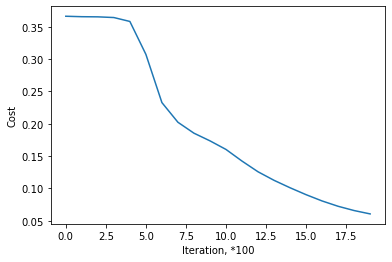

In [9]:
cls.fit(X_train, Y_train_transf)

In [10]:
print(cls.parameters)

{'W1': array([[-4.75779860e-03, -3.53851034e-01,  1.05082769e-03,
        -3.93968233e-02],
       [ 3.10691581e-01, -5.66894449e-01,  1.60788736e-01,
         3.68389196e-01],
       [-1.63759267e+00,  6.64112037e-01, -9.40973550e-01,
        -2.03754459e+00],
       [ 1.19826419e+00, -8.97959188e-02,  8.54443796e-01,
         2.20494387e+00],
       [-3.02682969e-01,  2.70872212e-01, -1.78330485e-01,
        -4.34872061e-01],
       [ 3.45544845e-01, -2.78967496e-01,  1.86185375e-01,
         4.38796918e-01],
       [ 1.57090434e-01, -1.92748944e-01,  9.67074194e-02,
         1.89778912e-01],
       [-6.45401005e-02, -4.02743088e-01, -2.33520953e-02,
        -1.13581853e-01],
       [-2.07364740e-01,  5.44735369e-02, -1.11932591e-01,
        -2.71653543e-01],
       [ 8.90710521e-01, -4.87559637e-01,  1.55093530e+00,
         4.03636630e+00],
       [ 3.95587661e-02, -4.26911210e-02,  1.88129677e-02,
         1.70491307e-02],
       [ 1.53958268e-01, -5.46724363e-01,  7.65474990e-02,

In [11]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[0.01818971, 0.81102495, 0.17078535],
       [0.01970919, 0.86677032, 0.11352049],
       [0.0118629 , 0.30785299, 0.68028411],
       [0.00444886, 0.05567454, 0.9398766 ],
       [0.00571989, 0.08211421, 0.9121659 ],
       [0.97720941, 0.02081646, 0.00197413],
       [0.00671759, 0.11166815, 0.88161425],
       [0.00532172, 0.0754097 , 0.91926858],
       [0.0044925 , 0.05676861, 0.93873889],
       [0.00524051, 0.07343705, 0.92132244],
       [0.97644064, 0.02152541, 0.00203395],
       [0.9760066 , 0.02192569, 0.00206772],
       [0.02574129, 0.89414485, 0.08011386],
       [0.89987796, 0.09281613, 0.00730591],
       [0.01820375, 0.60611481, 0.37568144],
       [0.977706  , 0.02035846, 0.00193554],
       [0.01592516, 0.57047519, 0.41359965],
       [0.01275173, 0.2853551 , 0.70189316],
       [0.00607772, 0.08902041, 0.90490187],
       [0.00485354, 0.0646102 , 0.93053626],
       [0.01641628, 0.44470562, 0.5388781 ],
       [0.00566187, 0.08394729, 0.91039083],
       [0.

In [12]:
Y_train_hat = cls.predict(X_train)
Y_train_hat

array([1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2,
       1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2,
       2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 0, 2, 2, 2, 1, 0, 2, 0], dtype=int64)

In [13]:
accuracy_score(Y_train, Y_train_hat)

0.9416666666666667

In [14]:
Y_test_hat = cls.predict(X_test)
Y_test_hat

array([1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       2, 0, 1, 0, 1, 1, 1, 2], dtype=int64)

In [15]:
accuracy_score(Y_test, Y_test_hat)

0.9666666666666667